In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

**Using smaller version of MovieLens Dataset.**

In [2]:
dataset_link="https://files.grouplens.org/datasets/movielens/ml-100k.zip"

In [3]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "movielens"

if image_path.is_dir():
    print("Already exists")
else:
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "ml-100k.zip", "wb") as f:
    request = requests.get(dataset_link)
    print("Downloading...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "ml-100k.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Downloading...
Unzipping...


# EDA

In [4]:
data = pd.read_csv("data/movielens/ml-100k/u.data", delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
data.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
info = pd.read_csv("data/movielens/ml-100k/u.item", encoding='latin-1', delimiter='|',usecols=(0,1), names=('movie','title'))
info.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
data.describe()

,user,movie,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


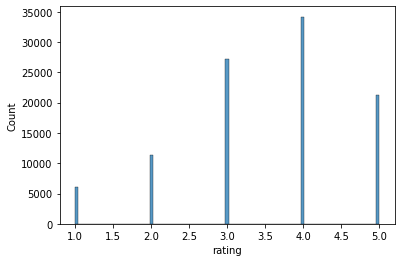

In [7]:
sns.histplot(data["rating"])

In [8]:
n_movies = len(data["movie"].unique())
n_users = len(data["user"].unique())
data_len = len(data)
print(f"There are {n_movies} unique movies, {n_users} unique users in a dataset of length {data_len}")

There are 1682 unique movies, 943 unique users in a dataset of length 100000


# Data Preparation

In [9]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [10]:
train_data.head()

,user,movie,rating,timestamp
0,230,498,5,880484755
1,141,120,4,884585547
2,449,105,1,879959573
3,922,217,3,891449993
4,694,215,3,875728181


In [11]:
class RatingsDatabase(torch.utils.data.Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df[["user", "movie"]].values)
        self.y = torch.tensor(df["rating"].values).reshape(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [12]:
train_data = RatingsDatabase(train_data)
test_data = RatingsDatabase(test_data)

In [13]:
x, y = train_data[0]
x, y

(tensor([230, 498]), tensor([5]))

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE=64

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [15]:
x, y = next(iter(train_dataloader))
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

# Training

In [16]:

class CollaborativeFiltering(nn.Module):
    def __init__(self, n_users, n_movies, n_factors):
        super().__init__()
        self.user_factors = nn.Embedding(n_users+1, n_factors)
        self.user_bias = nn.Embedding(n_users+1, 1)
        self.movie_factors = nn.Embedding(n_movies+1, n_factors)
        self.movie_bias = nn.Embedding(n_movies+1, 1)
    def forward(self, x):
        embeddings = self.user_factors(x[:,0]), self.movie_factors(x[:,1])
        out = (self.user_factors(x[:,0]) * self.movie_factors(x[:,1])).sum(dim=1)

        out += self.user_bias(x[:,0]).squeeze(dim=1) + self.movie_bias(x[:,1]).squeeze(dim=1)
        return out

In [17]:
model = CollaborativeFiltering(n_users, n_movies, 100)
model = model.to(device)

model

CollaborativeFiltering(
  (user_factors): Embedding(944, 100)
  (user_bias): Embedding(944, 1)
  (movie_factors): Embedding(1683, 100)
  (movie_bias): Embedding(1683, 1)
)

In [18]:
def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            

            y_preds = model(X)

            loss = loss_fn(y_preds, y)

            test_loss += loss

    test_loss = test_loss / len(dataloader)
    return test_loss

In [19]:
def train(train_dataloader, test_dataloader, epochs, model, optimizer, loss_fn):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            y_preds = model(X)

            loss = loss_fn(y_preds, y.float())

            train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        train_loss = train_loss / len(train_dataloader)
        test_loss = test_step(model, test_dataloader, loss_fn)
        print(f"Epoch: {epoch}, Train loss: {train_loss}, Test loss: {test_loss}")


In [20]:
EPOCHS = 60
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

train(train_dataloader, test_dataloader, EPOCHS, model, optimizer, loss_fn)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train loss: 89.19984961853028, Test loss: 66.29344177246094
Epoch: 1, Train loss: 33.52168171386719, Test loss: 46.573692321777344
Epoch: 2, Train loss: 14.35180810623169, Test loss: 35.71854782104492
Epoch: 3, Train loss: 7.035033599472046, Test loss: 29.108999252319336
Epoch: 4, Train loss: 4.118671584892273, Test loss: 24.70165252685547
Epoch: 5, Train loss: 3.013639826774597, Test loss: 21.67295265197754
Epoch: 6, Train loss: 2.873752912521362, Test loss: 19.17070960998535
Epoch: 7, Train loss: 3.0215173075675965, Test loss: 17.29816436767578
Epoch: 8, Train loss: 2.876821187114716, Test loss: 15.55244255065918
Epoch: 9, Train loss: 2.5928513909339905, Test loss: 14.229647636413574
Epoch: 10, Train loss: 2.4924474162101746, Test loss: 13.127471923828125
Epoch: 11, Train loss: 2.5369628710746763, Test loss: 12.198007583618164
Epoch: 12, Train loss: 2.542857374858856, Test loss: 11.207738876342773
Epoch: 13, Train loss: 2.452169682598114, Test loss: 10.446778297424316
Epoch

# Predicting

In [21]:
movie_embedding = model.movie_factors.weight
distances = nn.CosineSimilarity(dim=1)(movie_embedding, movie_embedding[5])
preds = distances.argsort(descending=True)[:5]


In [22]:
print("Liked film: ", info['title'][5]) 
for i, pred in enumerate(preds):
    print(f"Reccomended movie {i+1}: ", info['title'][data['movie'][pred.item()]])

Liked film:  Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Reccomended movie 1:  Trainspotting (1996)
Reccomended movie 2:  Flipper (1996)
Reccomended movie 3:  Henry V (1989)
Reccomended movie 4:  My Fair Lady (1964)
Reccomended movie 5:  Meet John Doe (1941)


# Saving Model

In [24]:
torch.save(model, "./model.pt")


In [25]:
%ls

data/  model.pt  sample_data/
